# Latents of LLC_MODIS_2012: Epoch 20

In [3]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [4]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [5]:
llc_modis_2012_data_path = "/home/jovyan/ulmo/ulmo/runs/SSL/experiments/datasets/llc_dataset/"
llc_modis_2012_data = os.path.join(llc_modis_2012_data_path, os.listdir(llc_modis_2012_data_path)[1])

In [6]:
with h5py.File(llc_modis_2012_data, 'r') as f:
    llc_modis_2012 = f['valid'][:]

In [7]:
print(llc_modis_2012.shape)

(635295, 1, 64, 64)


In [11]:
llc_modis_2012_latents_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl/experiments/LLC_MODIS_2012_latents/"
llc_modis_2012_latents = os.path.join(llc_modis_2012_latents_path, os.listdir(llc_modis_2012_latents_path)[1])

In [19]:
with h5py.File(llc_modis_2012_latents, 'r') as f:
    latents_llc_modis_2012 = f['valid'][:]

In [ ]:
latents_llc_modis_2012.shape
num_samples = latents_llc_modis_2012.shape[0]

In [21]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents_llc_modis_2012)
### Transform the latents
latents_std = scaler.transform(latents_llc_modis_2012)

In [22]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

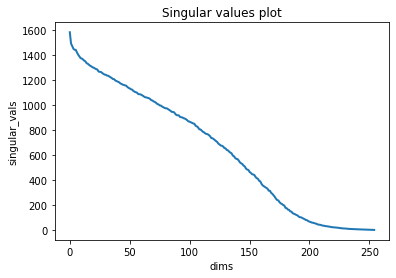

In [23]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [25]:
import umap

In [26]:
%%time 
reducer_umap = umap.UMAP()
latents_reduced = reducer_umap.fit_transform(latents_std)

CPU times: user 1h 36min 20s, sys: 18min 58s, total: 1h 55min 19s
Wall time: 20min 59s


In [27]:
### Store the latents
latents_umap_file = 'latents_umap_epoch_last.h5'
latents_umap_path = os.path.join(llc_modis_2012_latents_path, latents_umap_file)
save_key = 'latents_umap'
with h5py.File(latents_umap_path, 'w') as file:
    file.create_dataset(save_key, data=latents_reduced)

In [12]:
### read the latents
latents_umap_file = 'latents_umap_epoch_last.h5'
latents_umap_path = os.path.join(llc_modis_2012_latents_path, latents_umap_file)
save_key = 'latents_umap'
with h5py.File(latents_umap_path, 'r') as file:
    latents_reduced = file[save_key][:]

In [23]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 24min 50s, sys: 2min 43s, total: 27min 33s
Wall time: 14min


In [24]:
import umap.plot

In [ ]:
umap.plot.points(latents_mapping)

In [ ]:
umap.plot.connectivity(latents_mapping, show_points=False)

-----------------------------------------------

## Show the latents with the cutouts

In [15]:
num_samples = latents_reduced.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

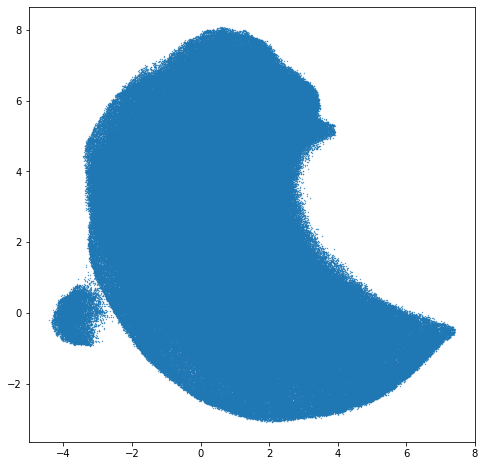

In [16]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)

In [17]:
from sklearn.neighbors import NearestNeighbors

In [18]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

In [19]:
### fix seed
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)
indice_sets = indices[indice_sampled]
dist_sets = distances[indice_sampled]

In [20]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

## Show the set 1

In [21]:
imgs_set = llc_modis_2012[indice_sets[0]]
dist_set = dist_sets[0]

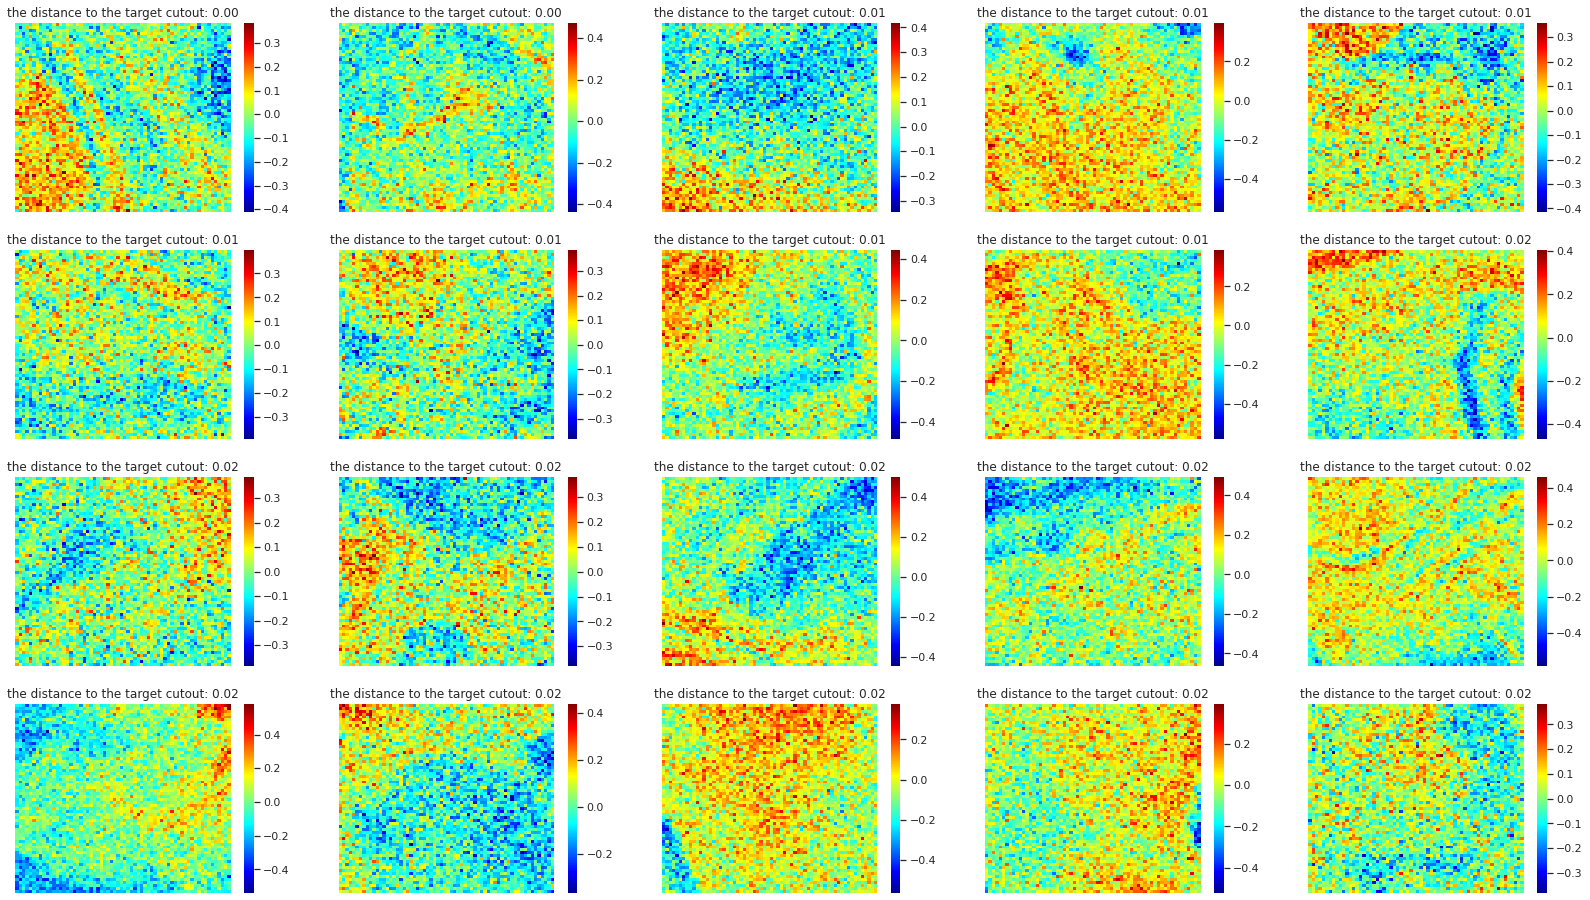

In [22]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 2

In [23]:
imgs_set = llc_modis_2012[indice_sets[1]]
dist_set = dist_sets[1]

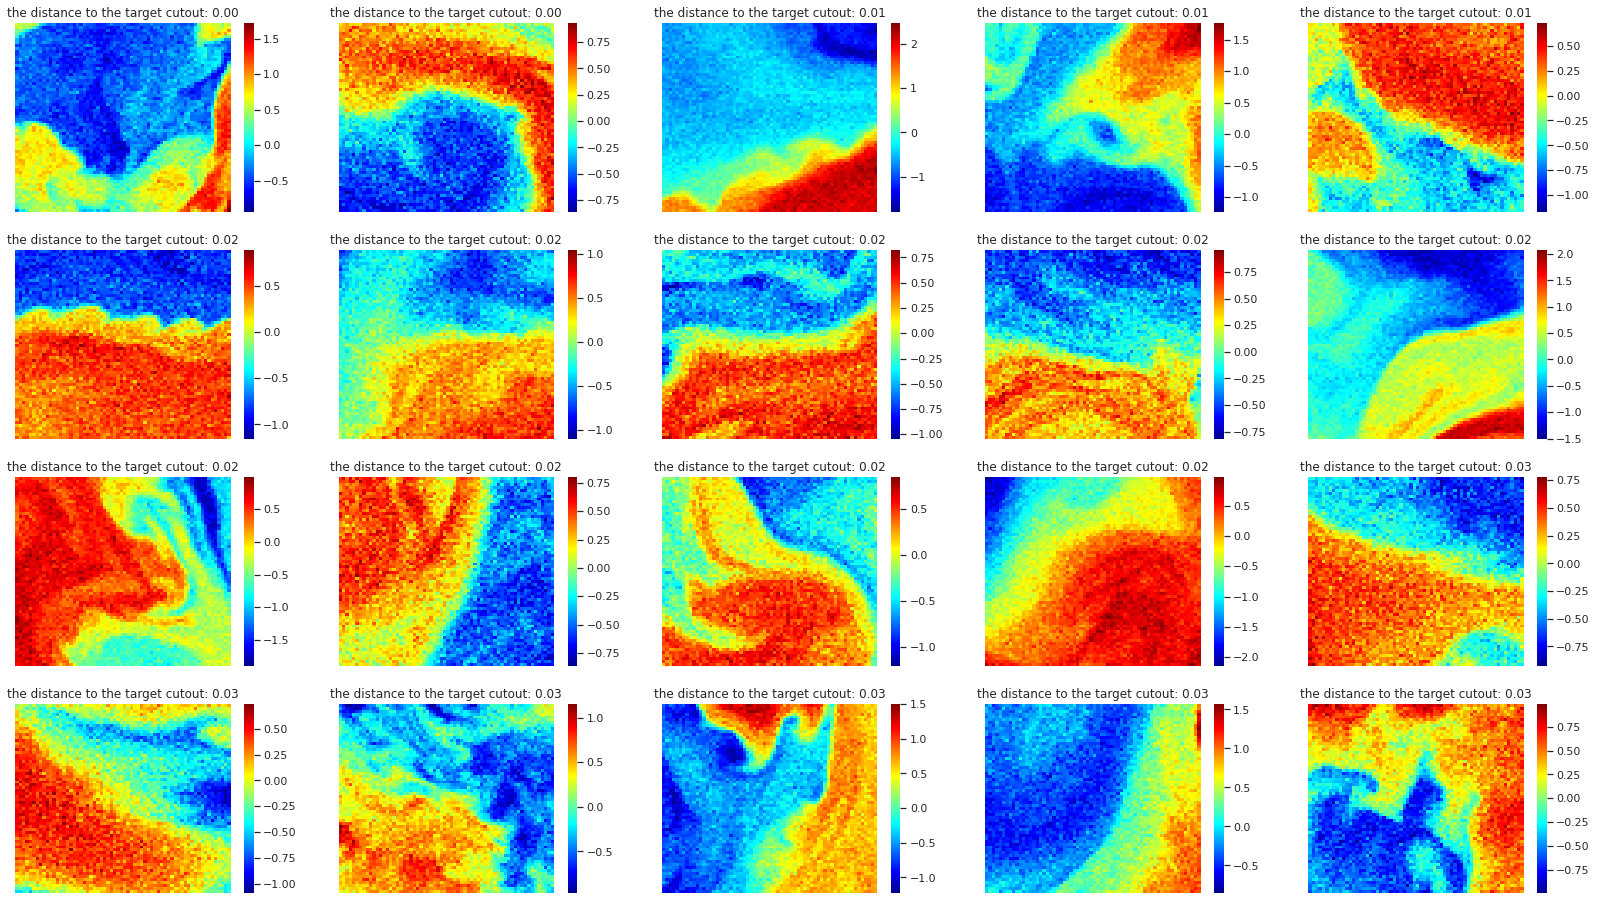

In [24]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 3

In [25]:
imgs_set = llc_modis_2012[indice_sets[2]]
dist_set = dist_sets[2]

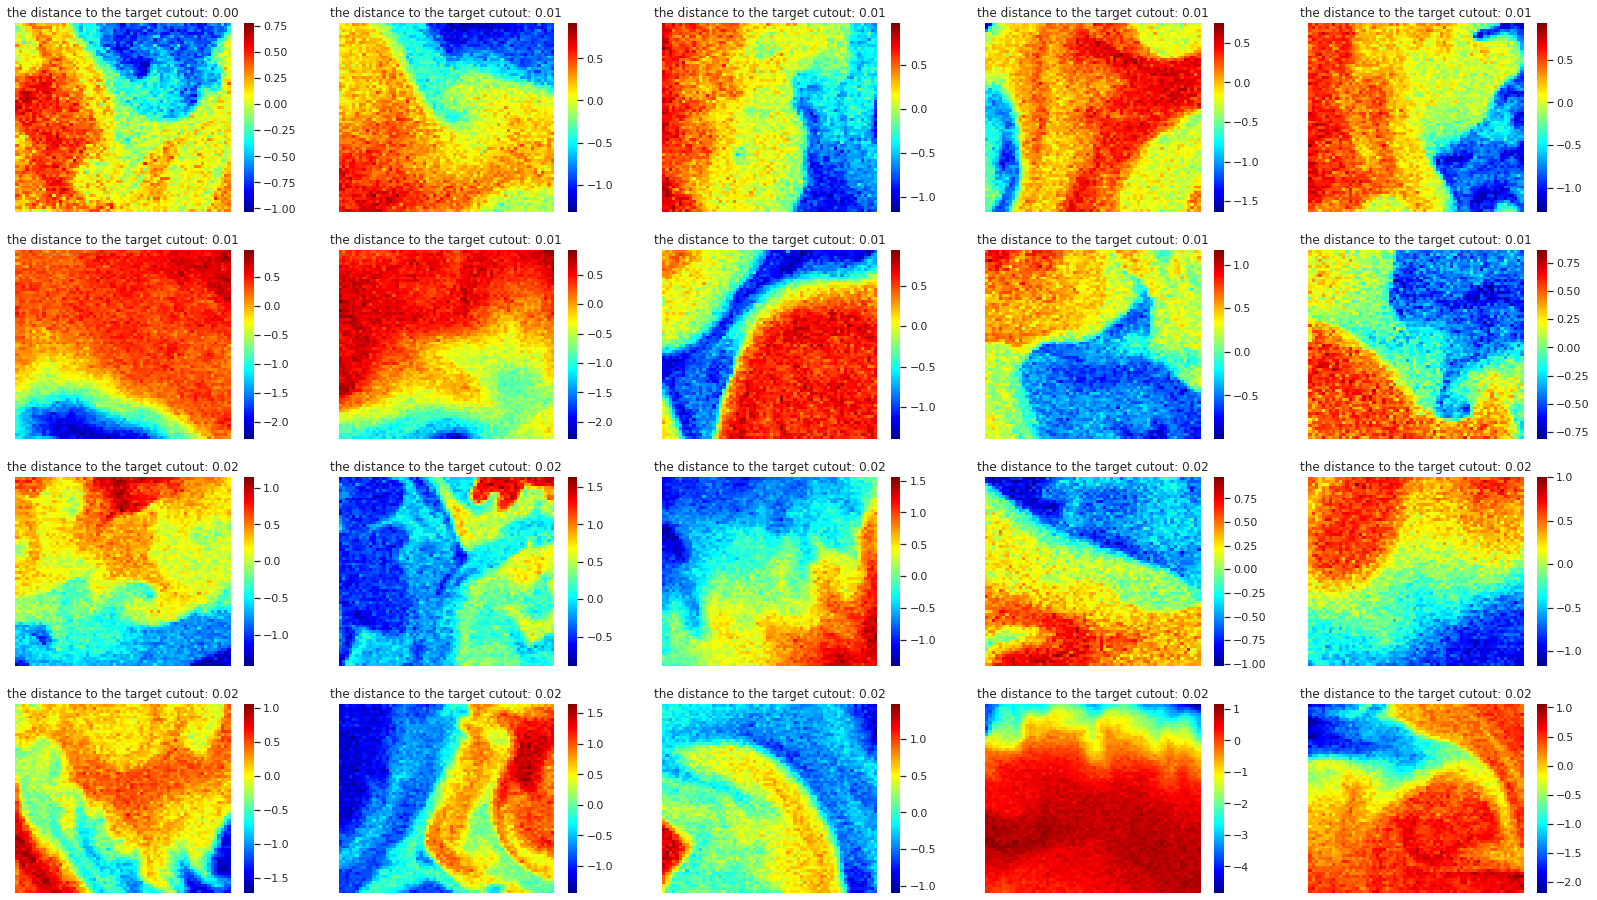

In [26]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 4

In [27]:
imgs_set = llc_modis_2012[indice_sets[3]]
dist_set = dist_sets[3]

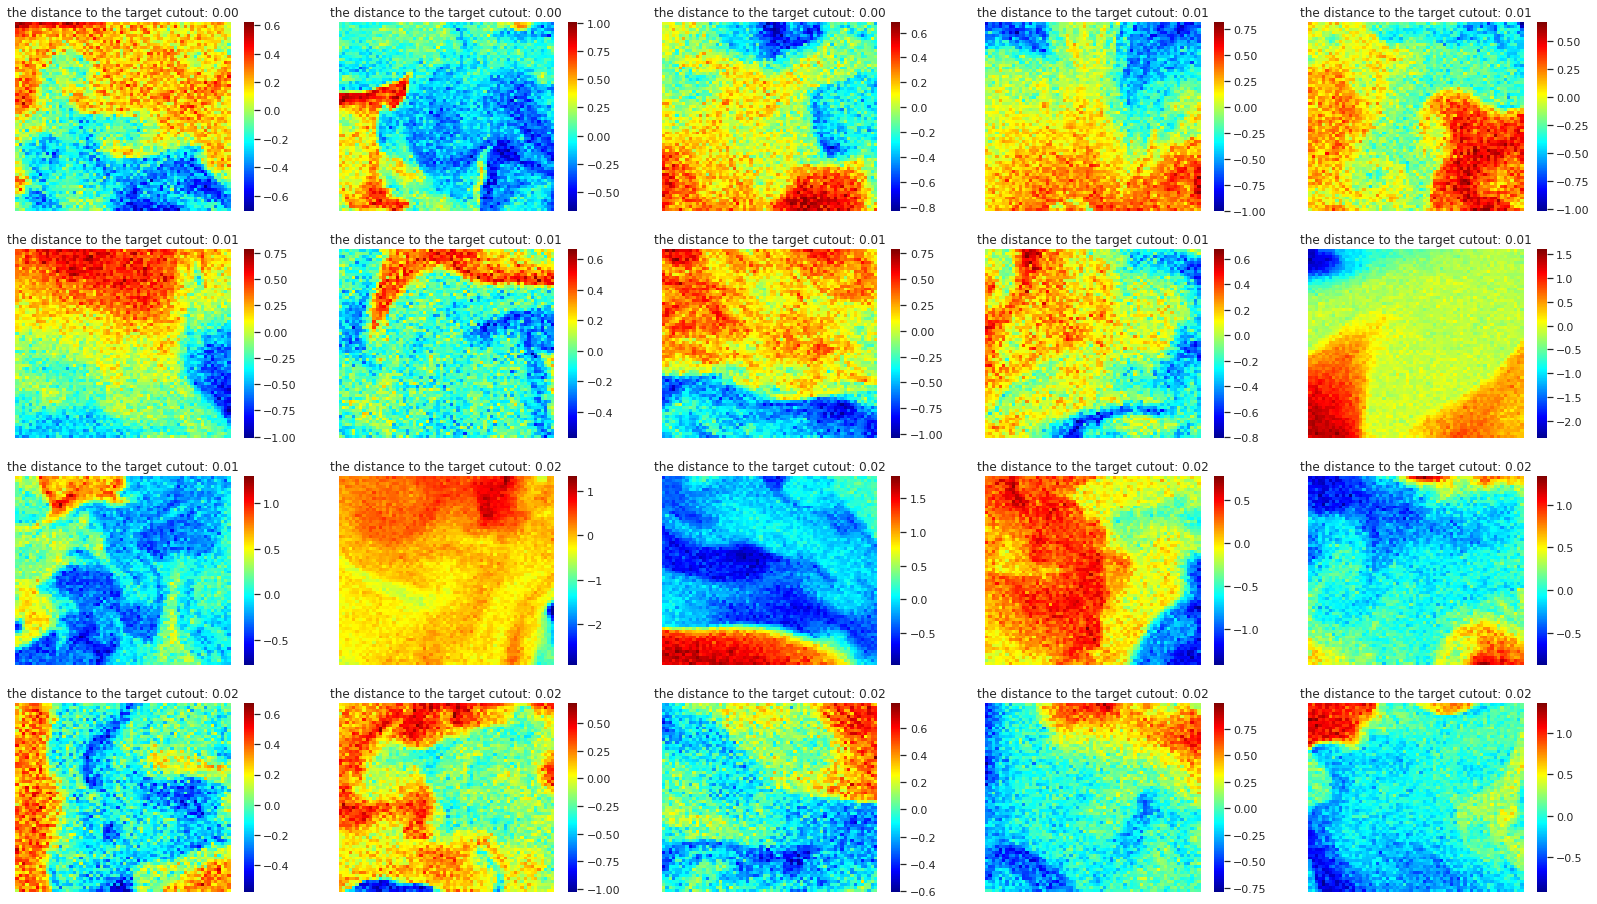

In [28]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

## Show the set 5

In [29]:
imgs_set = llc_modis_2012[indice_sets[4]]
dist_set = dist_sets[4]

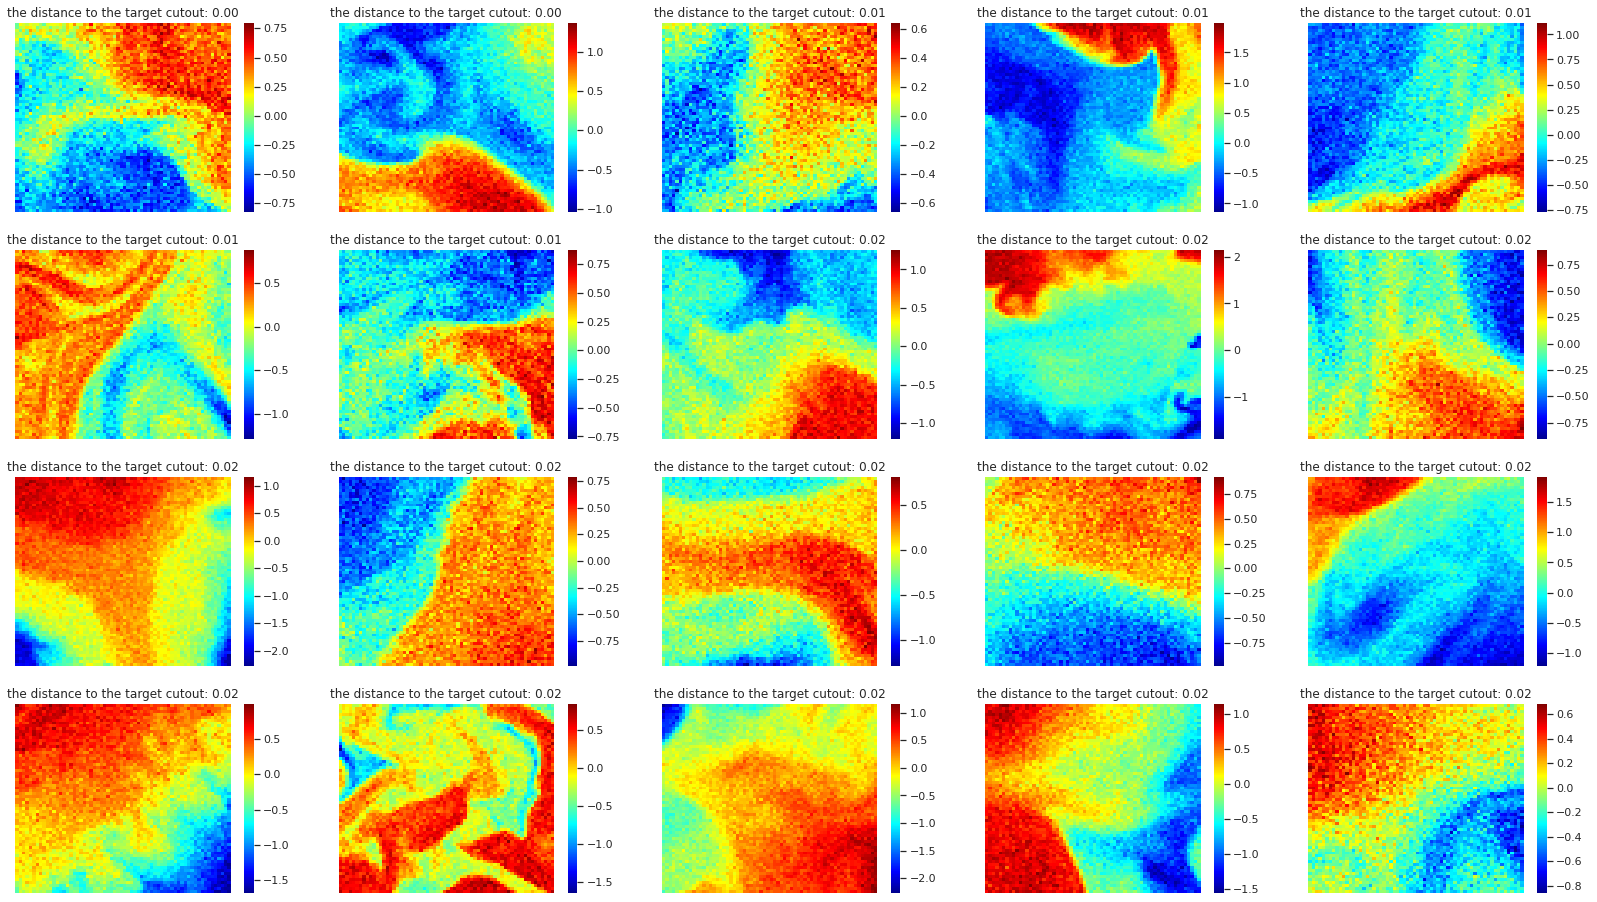

In [30]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

# Show the Scatter plot with cutouts

In [32]:
num_samples = latents_reduced.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

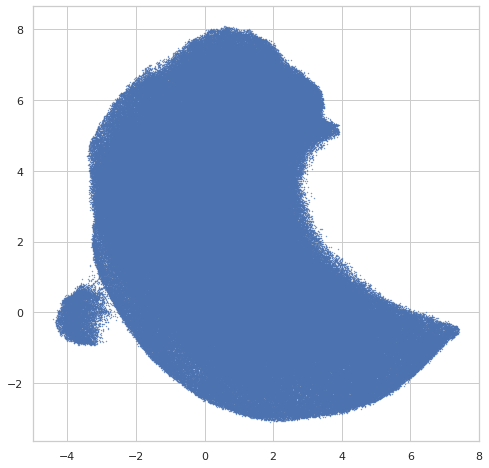

In [33]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)

In [34]:
latents_list = [latents_reduced[i, :] for i in indice_sets[0]]

In [35]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [36]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [37]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

In [38]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.patches import Rectangle
from matplotlib.cbook import get_sample_data

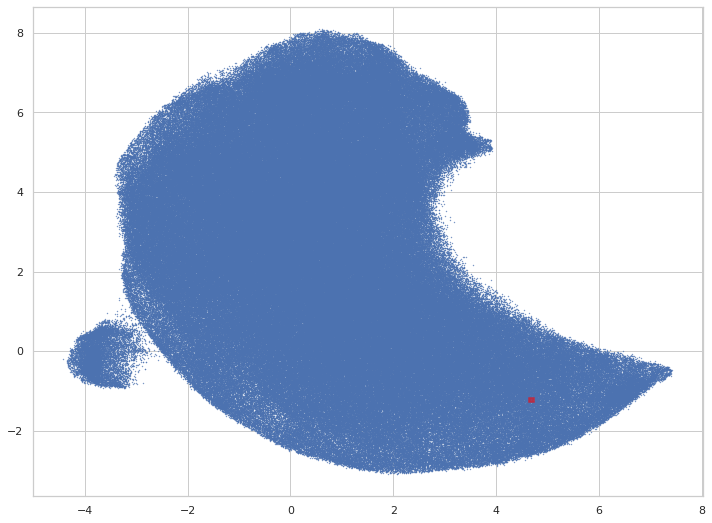

In [39]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(12, 9))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

In [40]:
imgs_set = llc_modis_2012[indice_sets[0]]
dist_set = dist_sets[0]

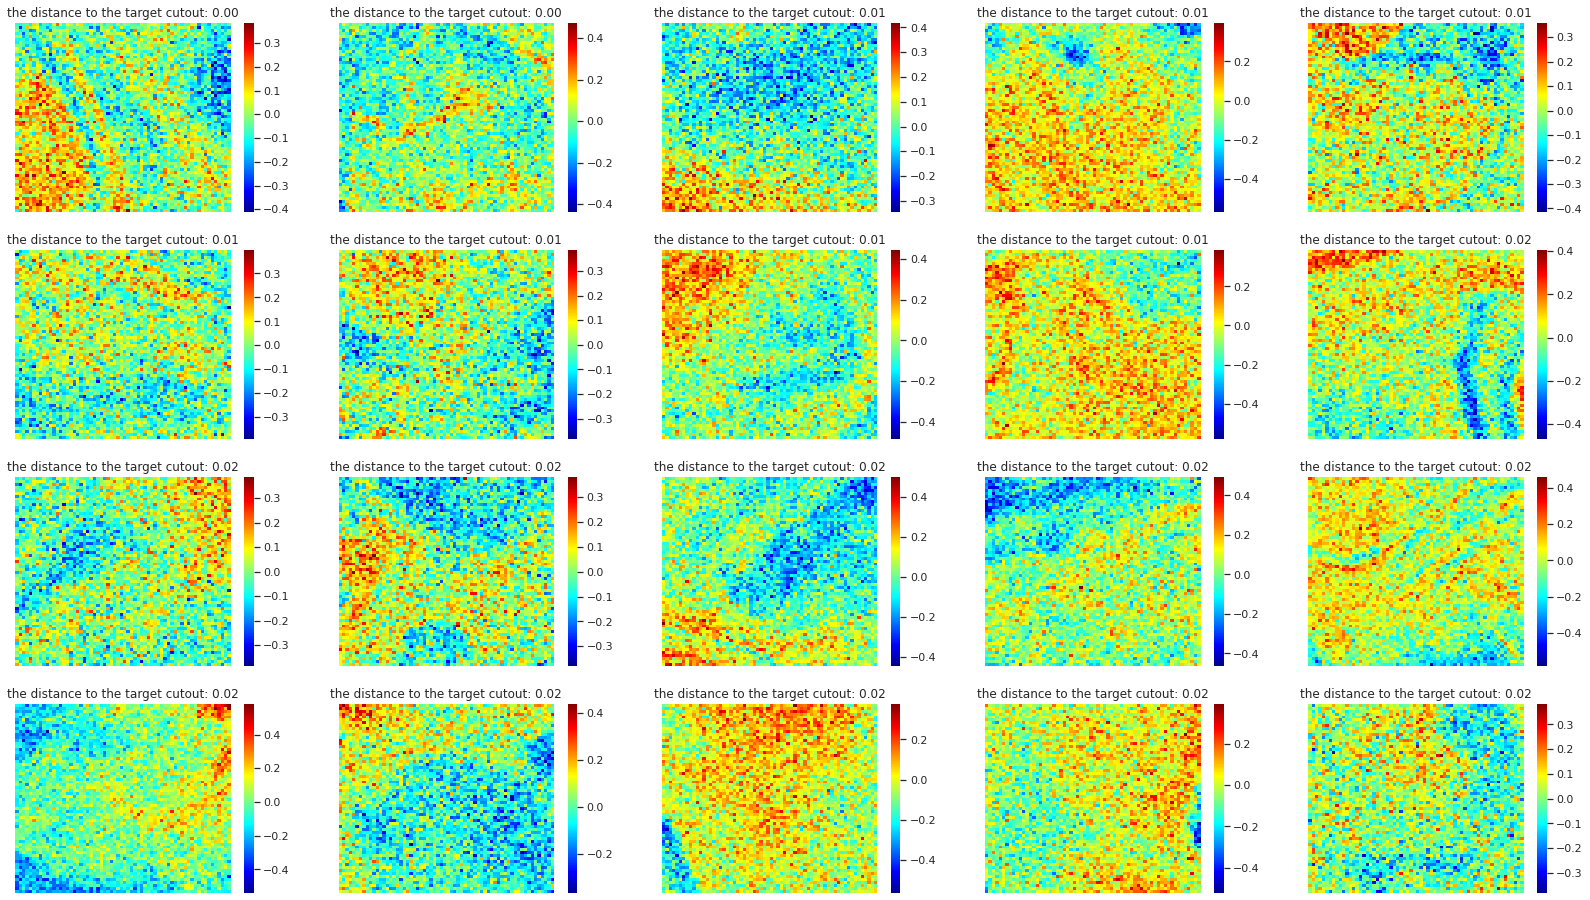

In [41]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [42]:
imgs_set = llc_modis_2012[indice_sets[1]]
dist_set = dist_sets[1]

In [43]:
latents_list = [latents_reduced[i, :] for i in indice_sets[1]]

In [44]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [45]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [46]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

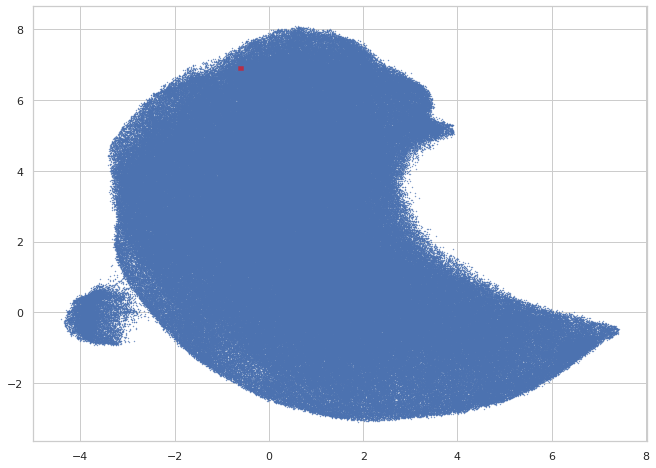

In [47]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        len_square, height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

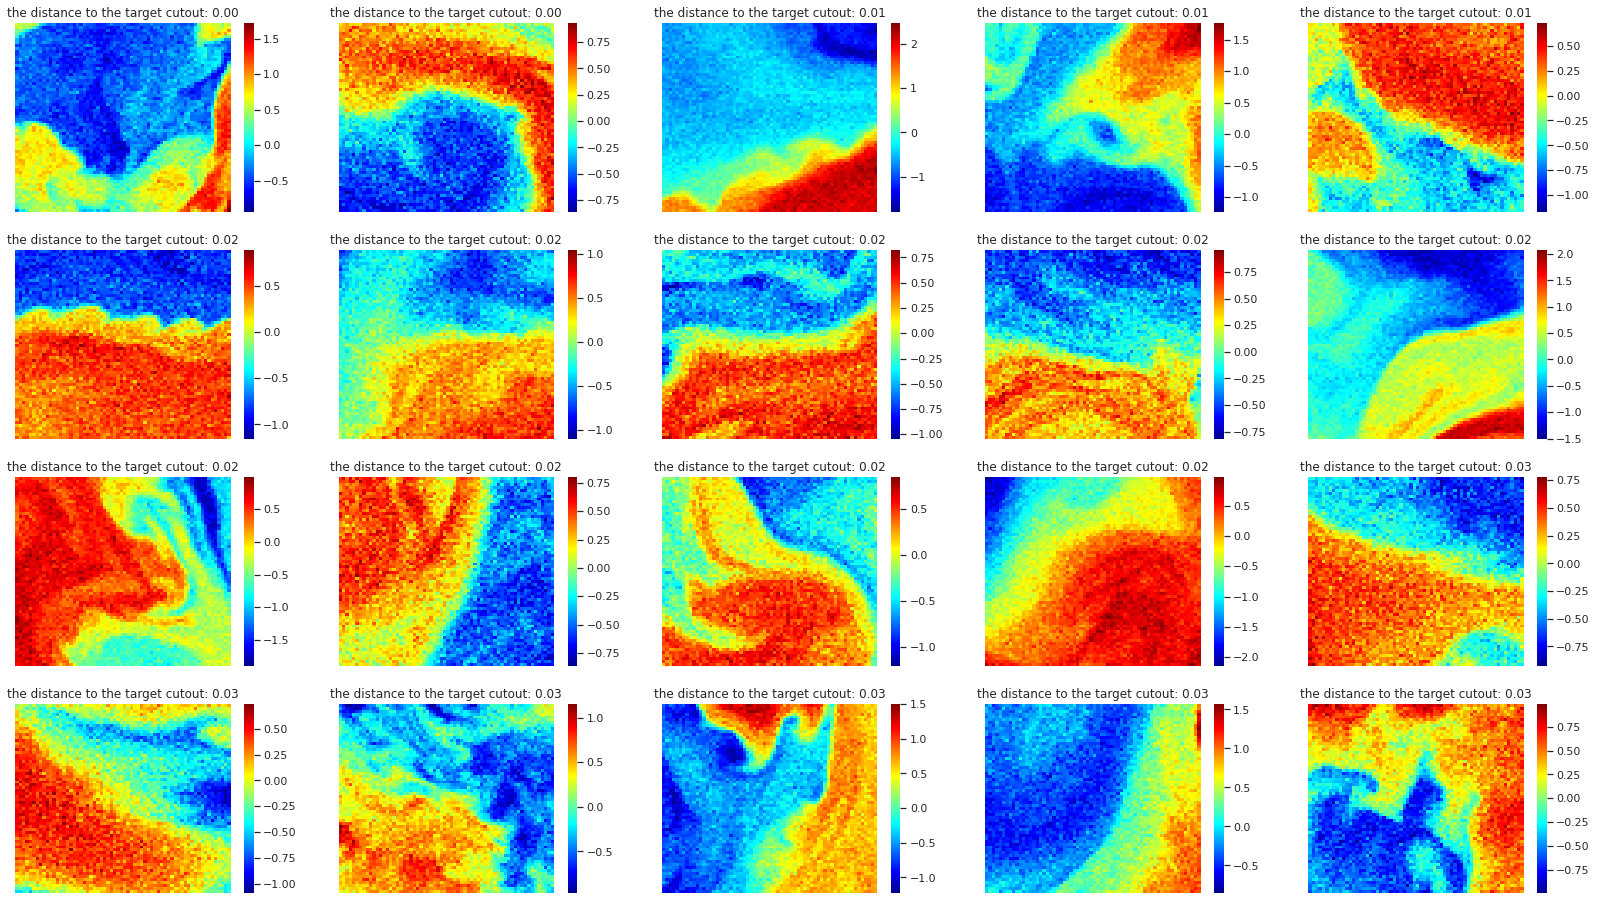

In [48]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [49]:
imgs_set = llc_modis_2012[indice_sets[2]]
dist_set = dist_sets[2]

In [50]:
latents_list = [latents_reduced[i, :] for i in indice_sets[2]]

In [51]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [52]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [53]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

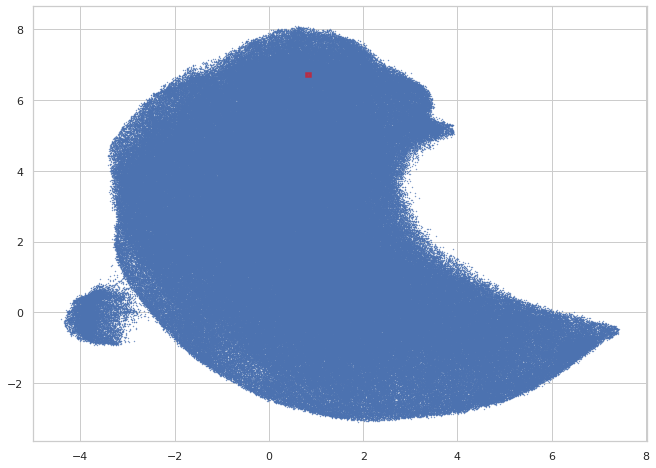

In [54]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

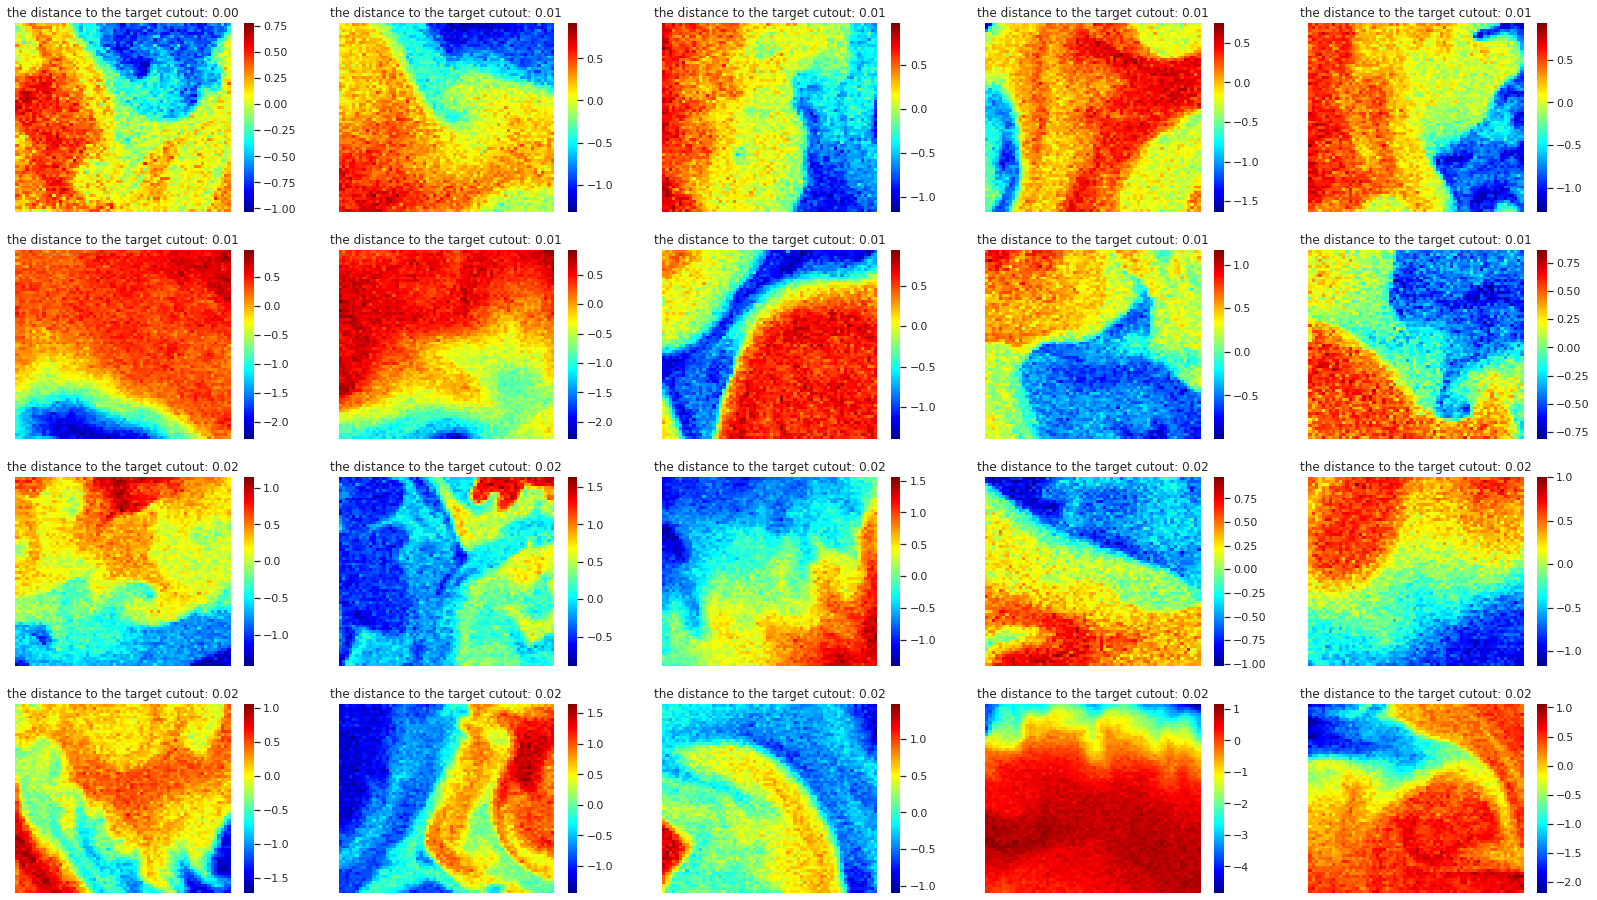

In [55]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [56]:
imgs_set = llc_modis_2012[indice_sets[3]]
dist_set = dist_sets[3]

In [57]:
latents_list = [latents_reduced[i, :] for i in indice_sets[3]]

In [58]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [59]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [60]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

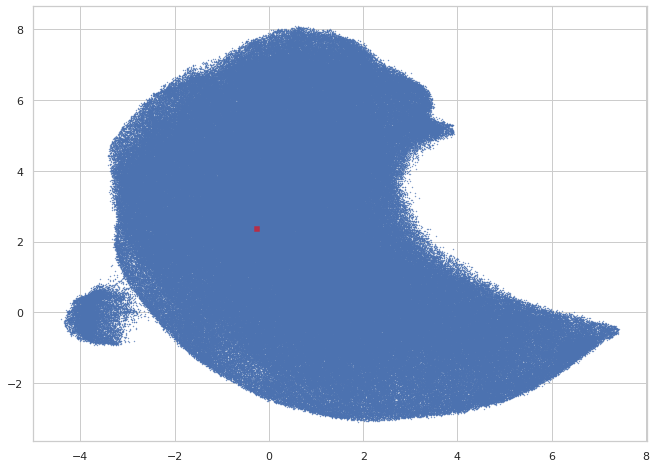

In [61]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

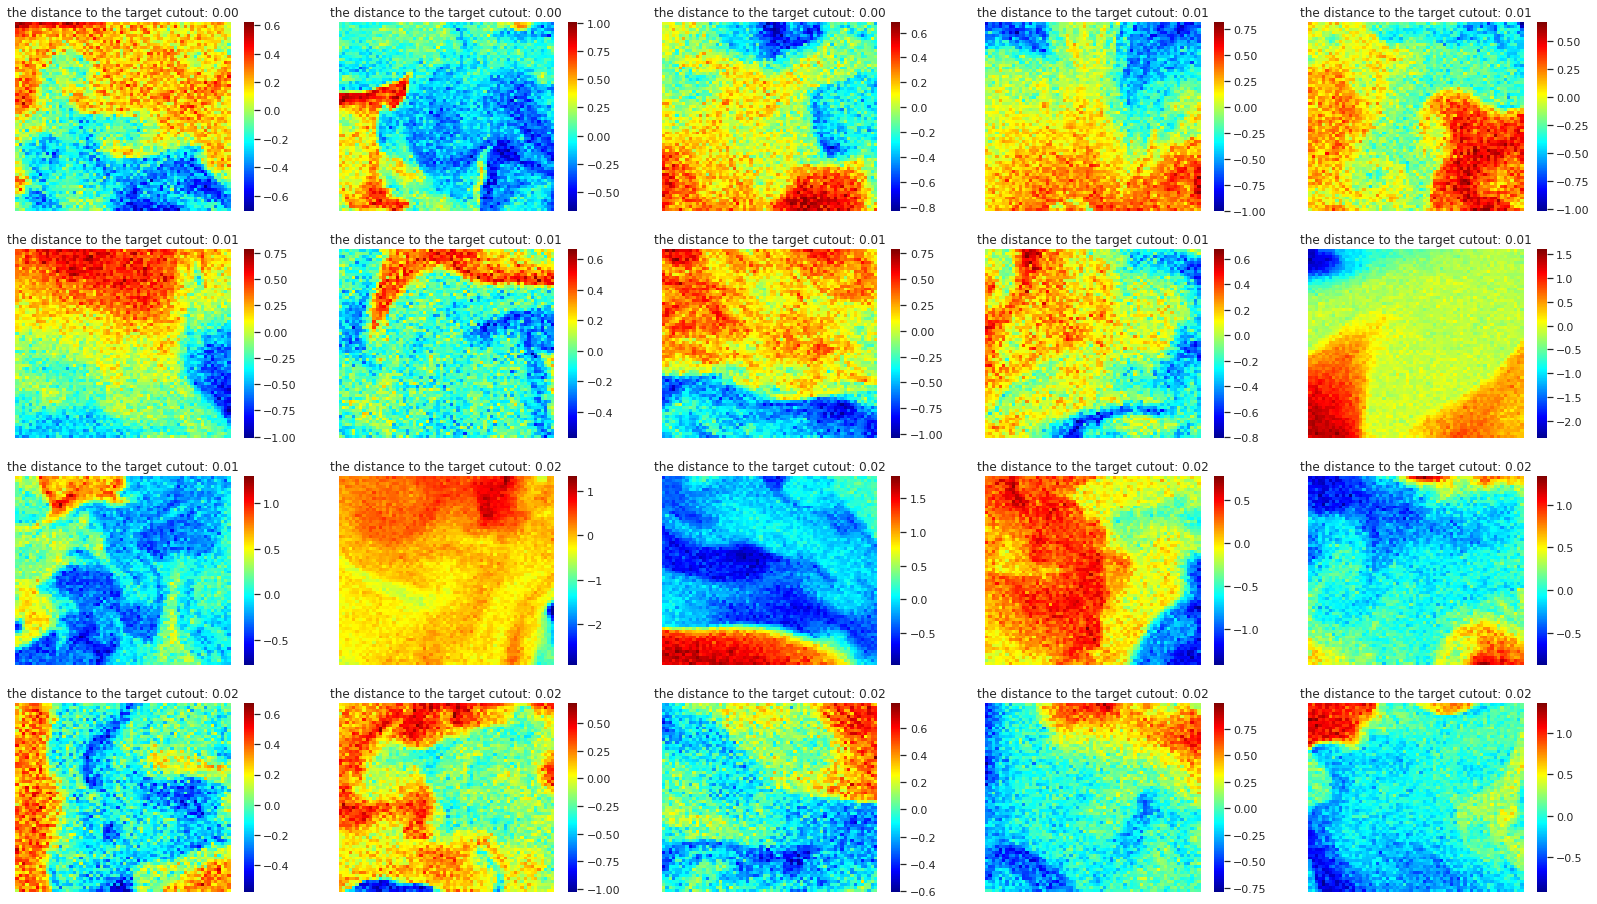

In [62]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')

In [63]:
imgs_set = llc_modis_2012[indice_sets[4]]
dist_set = dist_sets[4]

In [64]:
latents_list = [latents_reduced[i, :] for i in indice_sets[4]]

In [65]:
x_latents_list = [latents_list[i][0] for i in range(20)]
y_latents_list = [latents_list[i][1] for i in range(20)]

In [66]:
x_min, x_max = min(x_latents_list), max(x_latents_list)
y_min, y_max = min(y_latents_list), max(y_latents_list)

In [67]:
len_square = x_max - x_min
height_square = y_max - y_min
x_square = (x_min + x_max) / 2
y_square = (y_min + y_max) / 2

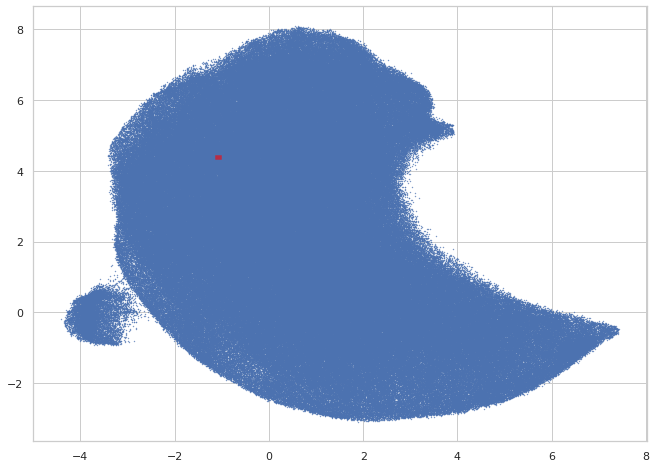

In [68]:
### set the plot of sns 
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()
fig, ax = plt.subplots(figsize=(11, 8))
plt.scatter(latents_reduced[:, 0], latents_reduced[:, 1], s=point_size)
ax.add_patch(Rectangle((x_square, y_square),
                        2*len_square, 2*height_square,
                        fc ='none', 
                        ec ='red',
                        lw = 2.5, 
                        alpha=0.6))

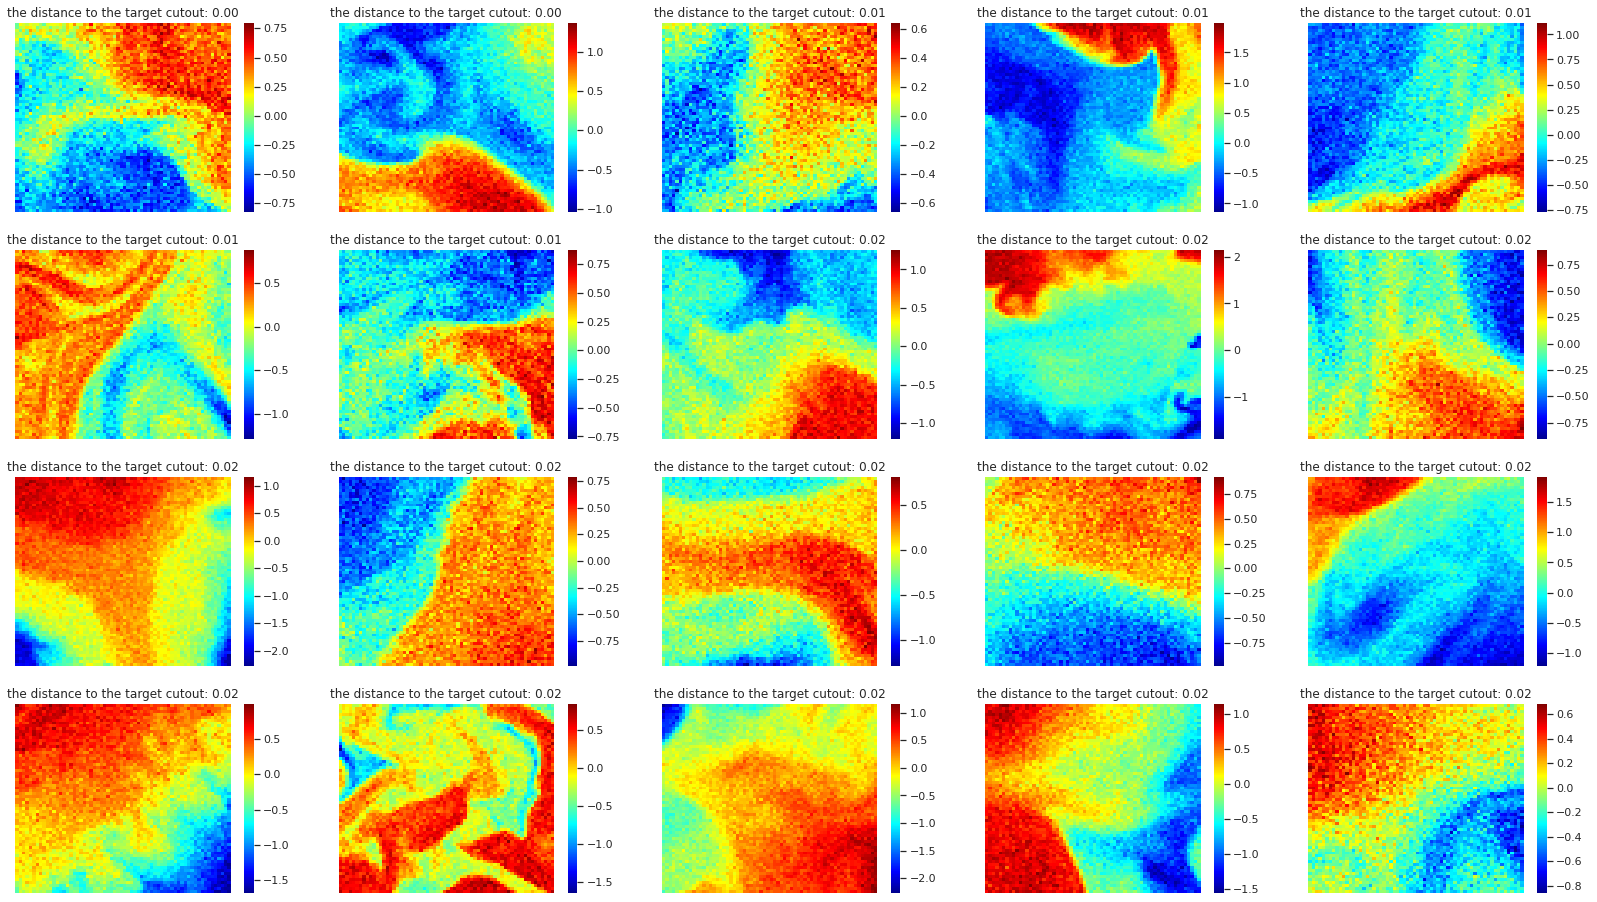

In [69]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(imgs_set[i][0], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist_set[i]:.2f}')